Подготовка данных к обучению

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from scipy.signal import savgol_filter, butter, filtfilt
from scipy import signal
from scipy.optimize import curve_fit
from scipy.fft import fft
from scipy.signal import medfilt
from scipy.signal import savgol_filter
from scipy.signal import hilbert
from matplotlib.collections import LineCollection
import pywt
load_dotenv()

import os
import warnings
warnings.filterwarnings('ignore')

Пути к данным (начнем с первого датасета)

In [2]:
first_dataset = pd.read_csv(os.environ['ECG_DATA_PATH_FIRST'], delimiter='\t', encoding='cp1251')

# Все датасеты тоже прогоним
second_dataset = pd.read_csv(os.environ['ECG_DATA_PATH_SECOND'], delimiter='\t', encoding='cp1251')
third_dataset = pd.read_csv(os.environ['ECG_DATA_PATH_THIRD'], delimiter='\t', encoding='cp1251',
                            	header=None, names=[f'column_{i}' for i in range(16)])

fourth_dataset = pd.read_csv(os.environ['ECG_DATA_PATH_FOURTH'], delimiter='\t', encoding='cp1251', 
                             header=None, names=[f'column_{i}' for i in range(16)])
first_dataset.head()

,"ПРКГ(3), мОм","ПРКГ(5), мОм","ПРКГ(7), мОм","ПРКГ(9), мОм","ПРКГ(13), мОм","ПРКГ(15), мОм","ЭКГ(16), мкВ","ПРКГ(18), мОм","ПРКГ(19), мОм","ПРКГ(20), мОм","ПРКГ(22), мОм","ПРКГ(24), мОм","ПРКГ(26), мОм","ПРКГ(30), мОм","ТРКГ(32), мОм",Unnamed: 15
0,-2.4,-2.4,-2.4,-2.8,-2.4,-2.8,12.986,-2.4,-1.2,-2.8,-2.8,-2.4,-2.4,-2.4,-2.0,NaN
1,-2.4,-2.8,-2.8,-2.8,-2.4,-2.8,5.565,-2.4,-1.2,-2.4,-2.8,-2.8,-2.4,-2.4,-2.0,NaN
2,-2.4,-3.2,-2.8,-2.8,-1.6,-2.4,-3.710,-1.6,-0.4,-1.6,-2.4,-2.8,-2.4,-2.8,-2.4,NaN
3,-2.4,-3.2,-3.2,-2.8,-0.4,-2.0,-7.420,-0.4,0.0,-0.8,-2.4,-3.6,-2.8,-2.8,-2.8,NaN
4,-2.8,-3.6,-4.0,-2.4,0.4,-1.6,-3.710,0.8,0.8,0.0,-2.4,-4.0,-2.8,-3.2,-3.2,NaN


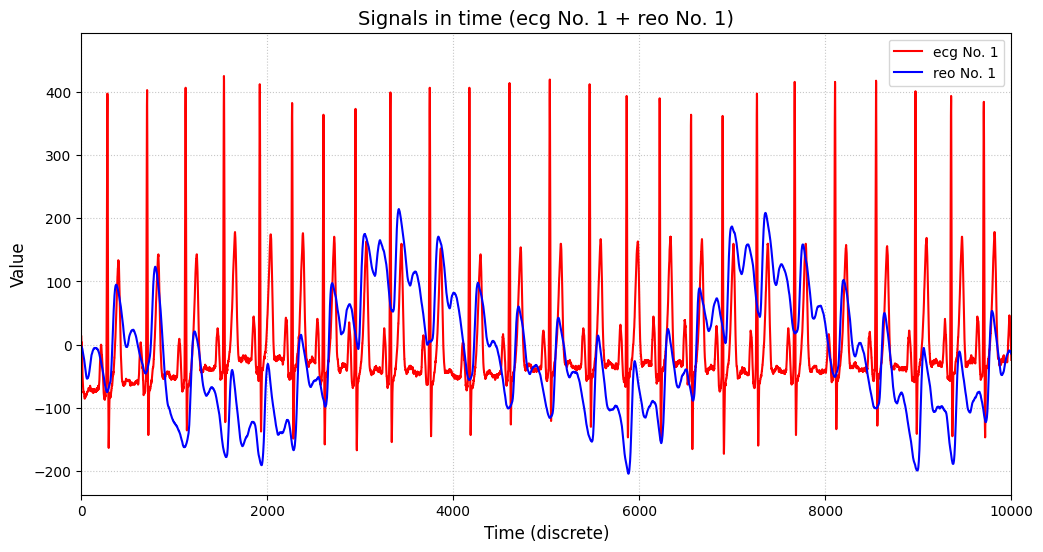

In [3]:
def plot_signals_common(signals_dataset, label_ecg, 
				 label_reo, 
				 column_name_ecg, 
				 column_name_reo,
				 lower_time_limit = 0, 
				 upper_time_limit = 1000, 
				 color_ecg = 'red',
				 color_reo='blue'):
	plt.figure(figsize=(12, 6))
	plt.plot(signals_dataset[column_name_ecg], label=label_ecg, color=color_ecg, linewidth=1.5)
	plt.plot(signals_dataset[column_name_reo], label=label_reo, color=color_reo, linewidth=1.5)
	plt.title(f'Signals in time ({label_ecg} + {label_reo})', fontsize=14)
	plt.xlabel('Time (discrete)', fontsize=12)
	plt.ylabel('Value', fontsize=12)
	plt.legend(fontsize=10)
	plt.grid(True, linestyle=':', alpha=0.7)
	plt.xlim
	plt.xlim([lower_time_limit, upper_time_limit])
	plt.show()

plot_signals_common(signals_dataset=first_dataset, 
			label_ecg='ecg No. 1',
			label_reo='reo No. 1',
			column_name_ecg='ЭКГ(16), мкВ', 
			column_name_reo='ТРКГ(32), мОм', 
			upper_time_limit=10000)

Для того, чтобы разметить данные, необходимо поработать с сигналами. Начнем с ```Рео```

Посчитаем элементарные статистики

In [4]:
mean_reo_first = first_dataset['ТРКГ(32), мОм'].mean()
median_reo_first = first_dataset['ТРКГ(32), мОм'].median()
std_reo_first = first_dataset['ТРКГ(32), мОм'].std(ddof=1)

print(f'Среднее значение для РЕО No. 1 {mean_reo_first}')
print(f'Медианное значение для РЕО No. 2 {median_reo_first}')
print(f'Значение дисперсии для РЕО No. 2 {std_reo_first}')

Среднее значение для РЕО No. 1 -0.25340829292413036
Медианное значение для РЕО No. 2 -9.2
Значение дисперсии для РЕО No. 2 70.85776427510748


Необходимо сгладить сигнал для получения гладкой апроксимации и формирования разметки

Рассмотрим различные типы сглаживания сигнала

1. Скользящее среднее

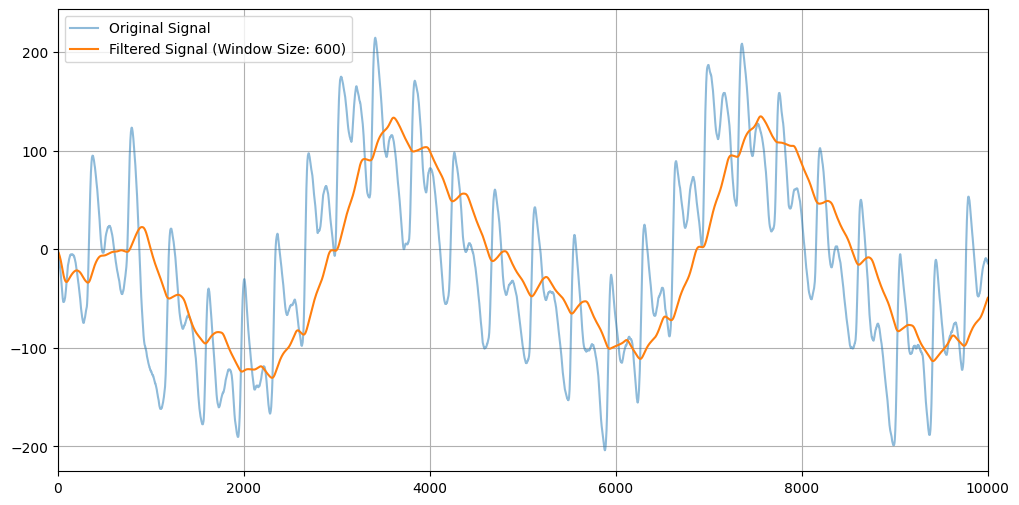

In [5]:
def moving_average_smooth(df, column, 
						window_size=10, 
						plot=False, 
						lower_time_limit = 0, 
						upper_time_limit = 1000):
	"""
	Сглаживание скользящим средним
	
	Параметры:
	df - DataFrame с данными
	column - название колонки для сглаживания
	window_size - размер окна сглаживания
	plot - если True, строит график
	lower_time_limit - левая граница по оси X
	upper_time_limit - правая граница по оси Y
	
	Возвращает:
	Series с сглаженными значениями
	"""
	smoothed = df[column].rolling(window=window_size, min_periods=1).mean()
	
	if plot:
		plt.figure(figsize=(12, 6))
		plt.plot(df[column], label='Original Signal', alpha=0.5)
		plt.plot(smoothed, label=f'Filtered Signal (Window Size: {window_size})')
		plt.legend()
		plt.xlim([lower_time_limit, upper_time_limit])
		plt.grid(True)
		plt.show()
	
	df['smoothed_ma'] = smoothed
	return df

first_dataset = moving_average_smooth(df=first_dataset,
										column='ТРКГ(32), мОм',
										window_size=600,
										plot=True,
										upper_time_limit=10000)

second_dataset = moving_average_smooth(df=second_dataset,
										column='ТРКГ(32), мОм',
										window_size=600,
										plot=False,
										upper_time_limit=10000)

third_dataset = moving_average_smooth(df=third_dataset,
										column='column_14',
										window_size=600,
										plot=False,
										upper_time_limit=10000)

fourth_dataset = moving_average_smooth(df=fourth_dataset,
										column='column_14',
										window_size=600,
										plot=False,
										upper_time_limit=10000)

2. Экспоненциальное сглаживание

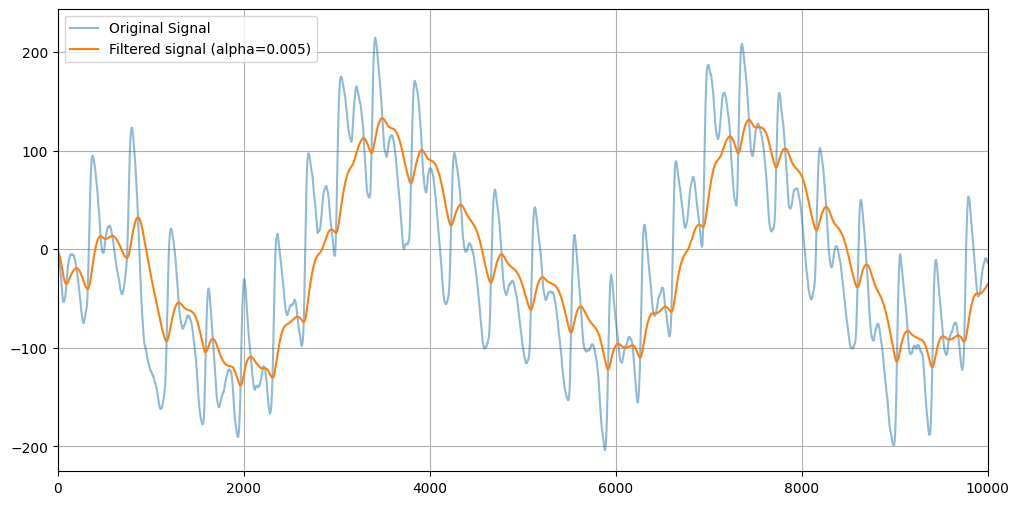

In [6]:
def exponential_smooth(df, column, alpha=0.2, plot=False,
					lower_time_limit = 0, 
						upper_time_limit = 1000):
	"""
	Экспоненциальное сглаживание
	
	Параметры:
	df - DataFrame с данными
	column - название колонки для сглаживания
	alpha - коэффициент сглаживания (0 < alpha < 1)
	plot - если True, строит график
	lower_time_limit - левая граница по оси X
	upper_time_limit - правая граница по оси Y
	
	Возвращает:
	Series с сглаженными значениями
	"""
	smoothed = df[column].ewm(alpha=alpha).mean()
	
	if plot:
		plt.figure(figsize=(12, 6))
		plt.plot(df[column], label='Original Signal', alpha=0.5)
		plt.plot(smoothed, label=f'Filtered signal (alpha={alpha})')
		plt.legend()
		plt.xlim([lower_time_limit, upper_time_limit])
		plt.grid(True)
		plt.show()
	
	df['smoothed_ema'] = smoothed
	return df

first_dataset = exponential_smooth(df=first_dataset,
											alpha=0.005,
										column='ТРКГ(32), мОм',
										plot=True,
										upper_time_limit=10000)

second_dataset = exponential_smooth(df=second_dataset,
										column='ТРКГ(32), мОм',
											alpha=0.005,
										plot=False,
										upper_time_limit=10000)

third_dataset = exponential_smooth(df=third_dataset,
										column='column_14',
											alpha=0.005,
										plot=False,
										upper_time_limit=10000)

fourth_dataset = exponential_smooth(df=fourth_dataset,
										column='column_14',
											alpha=0.005,
										plot=False,
										upper_time_limit=10000)

3. Медианный фильтр

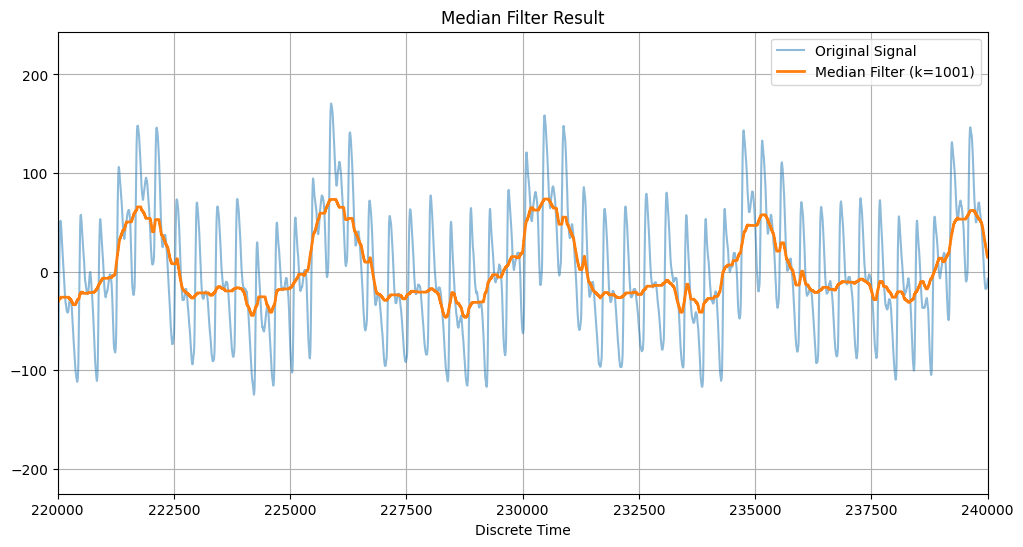

In [7]:
def enhanced_median_filter(signal, kernel_size=3, pad_mode='reflect'):
    """
    Улучшенный медианный фильтр с обработкой краев
    
    Параметры:
    signal - входной сигнал
    kernel_size - размер окна фильтрации
    pad_mode - метод дополнения краев:
        'reflect' (по умолчанию), 'nearest', 'constant' и др.
    
    Возвращает:
    Отфильтрованный сигнал
    """
    if kernel_size % 2 == 0:
        raise ValueError("Размер ядра должен быть нечетным")
    
    pad_width = kernel_size // 2
    padded = np.pad(signal, pad_width, mode=pad_mode)
    
    result = np.zeros_like(signal)
    for i in range(len(signal)):
        window = padded[i:i+kernel_size]
        result[i] = np.median(window)
    
    return result

def apply_median_filter_to_df(df, column, kernel_size=1001, 
                            x_column=None, plot=False, figsize=(12,6), 
                            xlim=[0, 10000]):
    """
    Применяет медианный фильтр к колонке DataFrame
    
    Параметры:
    df - исходный DataFrame
    column - название колонки с сигналом
    kernel_size - размер окна фильтрации
    x_column - колонка с x-значениями (для plotting)
    plot - визуализировать результат
    figsize - размер графика
    
    Возвращает:
    Копию DataFrame с добавленной колонкой 'median_filtered'
    """
    signal = df[column].values
    filtered = enhanced_median_filter(signal, kernel_size)
    
    result_df = df.copy()
    result_df['median_filtered'] = filtered
    
    if plot:
        x = df[x_column].values if x_column else np.arange(len(df))
        
        plt.figure(figsize=figsize)
        plt.plot(x, signal, label='Original Signal', alpha=0.5)
        plt.plot(x, filtered, label=f'Median Filter (k={kernel_size})', linewidth=2)
        plt.legend()
        plt.grid(True)
        plt.xlim(xlim)
        plt.title('Median Filter Result')
        plt.xlabel(x_column if x_column else 'Discrete Time')
        plt.show()
    
    return result_df

first_dataset = apply_median_filter_to_df(df=first_dataset, column='ТРКГ(32), мОм',
                                          xlim=[220000, 240000],
                                        plot=True, figsize=(12,6))

second_dataset = apply_median_filter_to_df(df=second_dataset,
										column='ТРКГ(32), мОм',
										plot=False,
										)

third_dataset = apply_median_filter_to_df(df=third_dataset,
										column='column_14',
										plot=False,
										)

fourth_dataset = apply_median_filter_to_df(df=fourth_dataset,
										column='column_14',
										plot=False,
										)

4. Полиномиальная аппроксимация

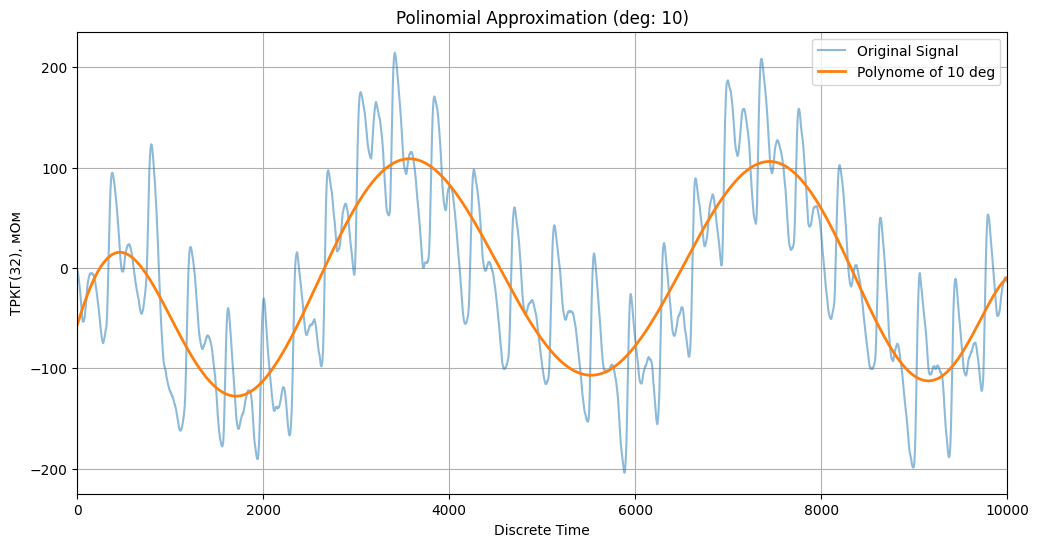

In [8]:
def polynomial_approximation_df(df, column, x_column=None, degree=10, plot=False, 
                              xlim=None, ylim=None, figsize=(12, 6),
                              up_border = 10000):
    """
    Аппроксимация сигнала из DataFrame полиномом
    
    Параметры:
    df - DataFrame с данными
    column - название колонки с сигналом
    x_column - название колонки с x-значениями (если None - используется индекс)
    degree - степень полинома
    plot - отображать график
    xlim - пределы по оси X (кортеж)
    ylim - пределы по оси Y (кортеж)
    figsize - размер графика
    
    Возвращает:
    df с добавленной колонкой 'poly_approx'
    coeffs - коэффициенты полинома
    """
    y = df[column].values[:10000]
    x = df[x_column].values[:10000] if x_column else df.index.values[:10000]
    
    coeffs = np.polyfit(x, y, degree)
    poly = np.poly1d(coeffs)
    result = poly(x)
    
    if plot:
        plt.figure(figsize=figsize)
        plt.plot(x, y, label='Original Signal', alpha=0.5)
        plt.plot(x, result, label=f'Polynome of {degree} deg', linewidth=2)
        plt.legend()
        plt.grid(True)
        if xlim: plt.xlim(*xlim)
        if ylim: plt.ylim(*ylim)
        plt.title(f'Polinomial Approximation (deg: {degree})')
        plt.xlabel(x_column if x_column else 'Discrete Time')
        plt.ylabel(column)
        plt.show()
    
    return df, coeffs

first_dataset, coeffs = polynomial_approximation_df(df=first_dataset,
                                                          xlim=[0, 10000],
                                                          column='ТРКГ(32), мОм',
                                                          plot=True)

Мягкая аппроксимация, но нужно идти в таком случае окном

5. Вейвлет-фильтрация (Хаара)

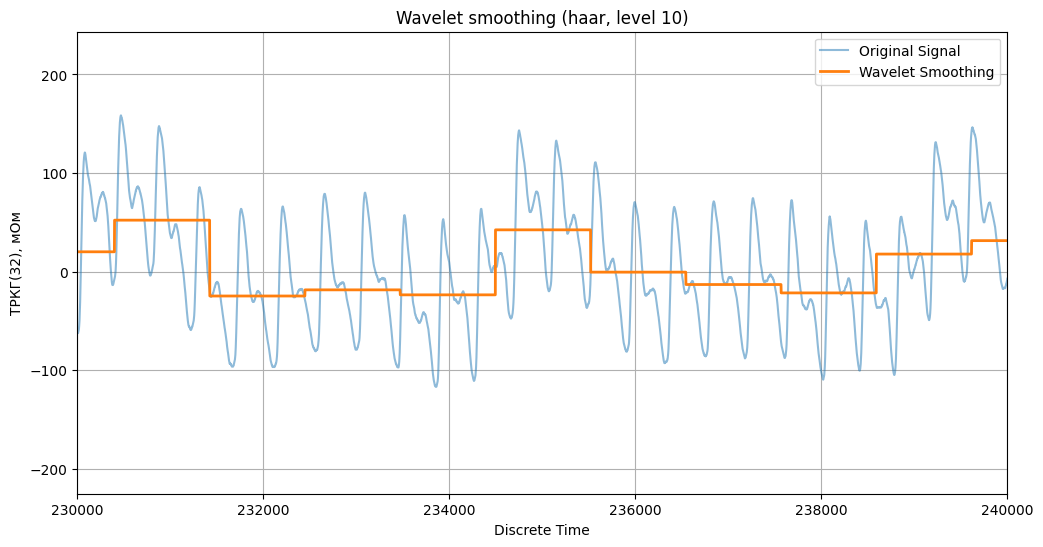

In [9]:
def wavelet_denoising_df(df, column, wavelet='haar', level=10, threshold_type='soft', 
                        plot=False, x_column=None, xlim=None, ylim=None, figsize=(12, 6), 
                        column_new = 'haar_wavelet'):
    """
    Вейвлет-сглаживание сигнала из DataFrame
    
    Параметры:
    df - DataFrame с данными
    column - название колонки с сигналом
    wavelet - тип вейвлета
    level - уровень декомпозиции
    threshold_type - тип порога ('soft' или 'hard')
    plot - отображать график
    x_column - название колонки с x-значениями
    xlim - пределы по оси X
    ylim - пределы по оси Y
    figsize - размер графика
    
    Возвращает:
    df с добавленной колонкой 'wavelet_denoised'
    """
    data = df[column].values
    
    coeffs = pywt.wavedec(data, wavelet, level=level)
    sigma = np.median(np.abs(coeffs[-level])) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(data)))
    coeffs[1:] = [pywt.threshold(c, threshold, mode=threshold_type) for c in coeffs[1:]]
    
    smoothed = pywt.waverec(coeffs, wavelet)
    df[column_new] = smoothed[:len(data)]
    
    if plot:
        x = df[x_column].values if x_column else df.index.values
        plt.figure(figsize=figsize)
        plt.plot(x, data, label='Original Signal', alpha=0.5)
        plt.plot(x, df[column_new], label='Wavelet Smoothing', linewidth=2)
        plt.legend()
        plt.grid(True)
        if xlim: plt.xlim(*xlim)
        if ylim: plt.ylim(*ylim)
        plt.title(f'Wavelet smoothing ({wavelet}, level {level})')
        plt.xlabel(x_column if x_column else 'Discrete Time')
        plt.ylabel(column)
        plt.show()
    
    return df

first_dataset = wavelet_denoising_df(df=first_dataset,
                                           column='ТРКГ(32), мОм',
                                           plot=True,
                                           xlim=[230000, 240000])

second_dataset = wavelet_denoising_df(df=second_dataset,
										column='ТРКГ(32), мОм',
										plot=False,
										)

third_dataset = wavelet_denoising_df(df=third_dataset,
										column='column_14',
										plot=False,
										)

fourth_dataset = wavelet_denoising_df(df=fourth_dataset,
										column='column_14',
										plot=False,
										)

Вейвлет Добеши

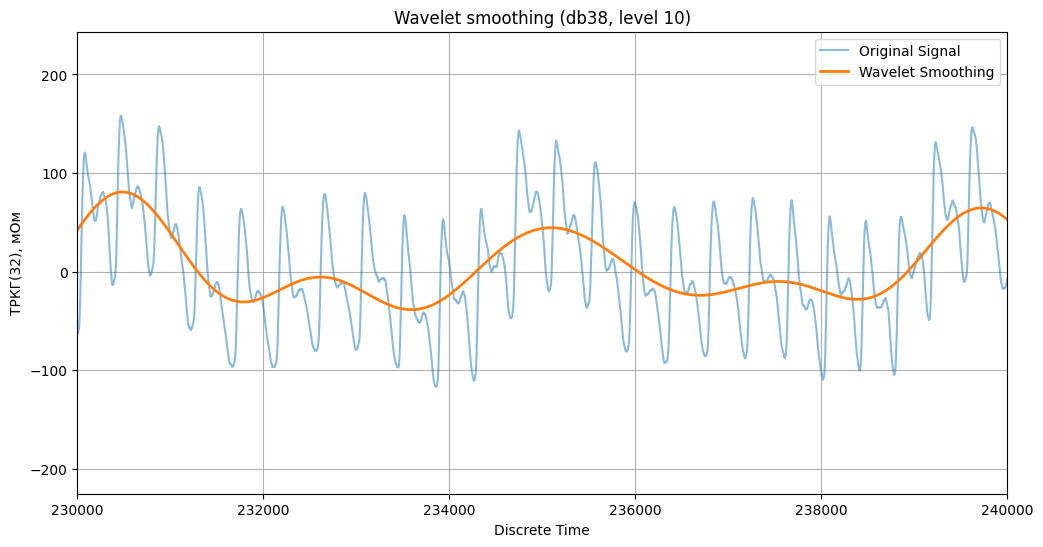

In [10]:
first_dataset = wavelet_denoising_df(df=first_dataset,
                                           column='ТРКГ(32), мОм',
                                           plot=True,
                                           wavelet='db38',
                                           xlim=[230000, 240000], 
                                           column_new='db_wavelet',
                                           )

second_dataset = wavelet_denoising_df(df=second_dataset,
										column='ТРКГ(32), мОм',
										plot=False,
										column_new='db_wavelet',
                                         wavelet='db38',
                                        )

third_dataset = wavelet_denoising_df(df=third_dataset,
										column='column_14',
										plot=False,
										column_new='db_wavelet',
                                         wavelet='db38',
                                        )

fourth_dataset = wavelet_denoising_df(df=fourth_dataset,
										column='column_14',
										plot=False,
										column_new='db_wavelet',
                                         wavelet='db38',
                                        )

7. Фильтр Баттерворта

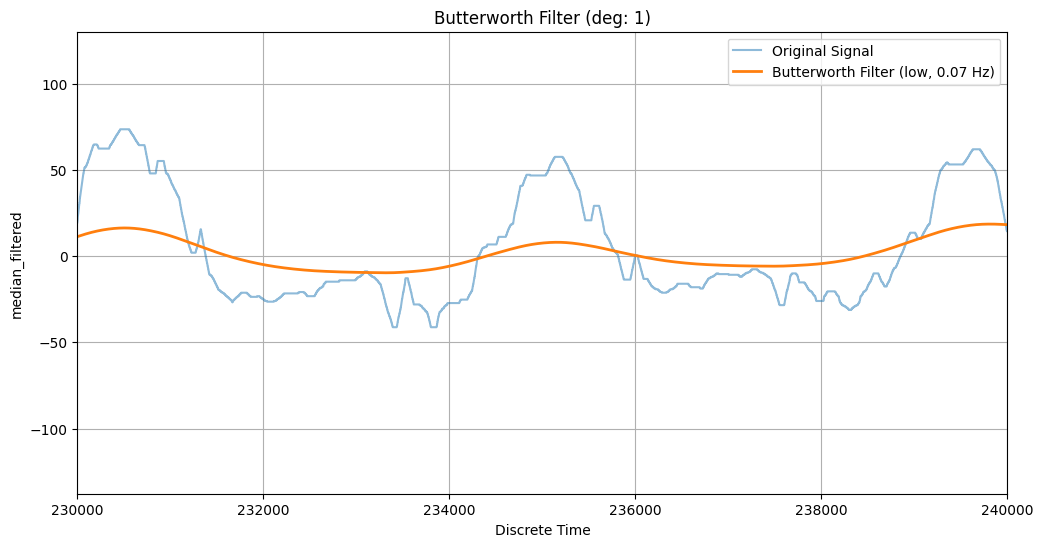

In [11]:
def butterworth_filter_df(df, column, cutoff, fs, order=5, filter_type='low',
                         plot=False, x_column=None, xlim=None, ylim=None, figsize=(12, 6)):
    """
    Фильтрация сигнала из DataFrame фильтром Баттерворта
    
    Параметры:
    df - DataFrame с данными
    column - название колонки с сигналом
    cutoff - частота среза (Гц)
    fs - частота дискретизации (Гц)
    order - порядок фильтра
    filter_type - тип фильтра ('low', 'high', 'band')
    plot - отображать график
    x_column - название колонки с x-значениями
    xlim - пределы по оси X
    ylim - пределы по оси Y
    figsize - размер графика
    
    Возвращает:
    df с добавленной колонкой 'butterworth_filtered'
    """
    data = df[column].values
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    
    b, a = signal.butter(order, normal_cutoff, btype=filter_type, analog=False)
    df['butterworth_filtered'] = signal.filtfilt(b, a, data)
    
    if plot:
        x = df[x_column].values if x_column else df.index.values
        plt.figure(figsize=figsize)
        plt.plot(x, data, label='Original Signal', alpha=0.5)
        plt.plot(x, df['butterworth_filtered'], 
                label=f'Butterworth Filter ({filter_type}, {cutoff} Hz)', 
                linewidth=2)
        plt.legend()
        plt.grid(True)
        if xlim: plt.xlim(*xlim)
        if ylim: plt.ylim(*ylim)
        plt.title(f'Butterworth Filter (deg: {order})')
        plt.xlabel(x_column if x_column else 'Discrete Time')
        plt.ylabel(column)
        plt.show()
    
    return df


first_dataset = butterworth_filter_df(df=first_dataset,
                                           column='median_filtered',
                                           order=1,
                                           fs=500,
                                           cutoff=0.07,
                                           plot=True,
                                           xlim=[230000, 240000])

second_dataset = butterworth_filter_df(df=second_dataset,
                                           column='median_filtered',
                                           order=1,
                                           fs=500,
                                           cutoff=0.07,
                                           plot=False,
                                           xlim=[230000, 240000])


third_dataset = butterworth_filter_df(df=third_dataset,
                                           column='median_filtered',
                                           order=1,
                                           fs=500,
                                           cutoff=0.07,
                                           plot=False,
                                           xlim=[230000, 240000])


fourth_dataset = butterworth_filter_df(df=fourth_dataset,
                                           column='median_filtered',
                                           order=1,
                                           fs=500,
                                           cutoff=0.07,
                                           plot=False,
                                           xlim=[230000, 240000])

In [12]:
first_dataset.head()

,"ПРКГ(3), мОм","ПРКГ(5), мОм","ПРКГ(7), мОм","ПРКГ(9), мОм","ПРКГ(13), мОм","ПРКГ(15), мОм","ЭКГ(16), мкВ","ПРКГ(18), мОм","ПРКГ(19), мОм","ПРКГ(20), мОм",...,"ПРКГ(26), мОм","ПРКГ(30), мОм","ТРКГ(32), мОм",Unnamed: 15,smoothed_ma,smoothed_ema,median_filtered,haar_wavelet,db_wavelet,butterworth_filtered
0,-2.4,-2.4,-2.4,-2.8,-2.4,-2.8,12.986,-2.4,-1.2,-2.8,...,-2.4,-2.4,-2.0,NaN,-2.000000,-2.000000,-10.4,-8.982031,-17.947907,-22.132034
1,-2.4,-2.8,-2.8,-2.8,-2.4,-2.8,5.565,-2.4,-1.2,-2.4,...,-2.4,-2.4,-2.0,NaN,-2.000000,-2.000000,-10.4,-8.982031,-17.902574,-22.142358
2,-2.4,-3.2,-2.8,-2.8,-1.6,-2.4,-3.710,-1.6,-0.4,-1.6,...,-2.4,-2.8,-2.4,NaN,-2.133333,-2.134002,-10.4,-8.982031,-17.857220,-22.152692
3,-2.4,-3.2,-3.2,-2.8,-0.4,-2.0,-7.420,-0.4,0.0,-0.8,...,-2.8,-2.8,-2.8,NaN,-2.300000,-2.301756,-10.4,-8.982031,-17.811847,-22.163035
4,-2.8,-3.6,-4.0,-2.4,0.4,-1.6,-3.710,0.8,0.8,0.0,...,-2.8,-3.2,-3.2,NaN,-2.480000,-2.483210,-10.4,-8.982031,-17.766455,-22.173387


Сравним фильтры при помощи энропийного критерия

In [47]:
import antropy as ant

spectral_entropy_original = ant.spectral_entropy(first_dataset['ТРКГ(32), мОм'], sf=600, method='welch', normalize=True)
spectral_entropy_ma = ant.spectral_entropy(first_dataset['smoothed_ma'], sf=600, method='welch', normalize=True)
spectral_entropy_ema = ant.spectral_entropy(first_dataset['smoothed_ema'], sf=600, method='welch', normalize=True)
spectral_entropy_wavelet_haar = ant.spectral_entropy(first_dataset['haar_wavelet'], sf=600, method='welch', normalize=True)
spectral_entropy_wavelet_db = ant.spectral_entropy(first_dataset['db_wavelet'], sf=600, method='welch', normalize=True)
spectral_entropy_butterworth = ant.spectral_entropy(first_dataset['butterworth_filtered'], sf=600, method='welch', normalize=True)
spectral_entropy_median = ant.spectral_entropy(first_dataset['median_filtered'], sf=600, method='welch', normalize=True)

sample_entropy_original = ant.sample_entropy(first_dataset['ТРКГ(32), мОм'])
sample_entropy_ma = ant.sample_entropy(first_dataset['smoothed_ma'])
sample_entropy_ema = ant.sample_entropy(first_dataset['smoothed_ema'])
sample_entropy_wavelet_haar = ant.sample_entropy(first_dataset['haar_wavelet'])
sample_entropy_wavelet_db = ant.sample_entropy(first_dataset['db_wavelet'])
sample_entropy_butterworth = ant.sample_entropy(first_dataset['butterworth_filtered'])
sample_entropy_median = ant.sample_entropy(first_dataset['median_filtered'])

entropy_dict = {'spectral_entropy': [
					spectral_entropy_original, 
					spectral_entropy_ma, 
					spectral_entropy_ema, 
					spectral_entropy_wavelet_haar, 
					spectral_entropy_wavelet_db, 
					spectral_entropy_butterworth,
                    spectral_entropy_median
                ], 
                'sample_entropy': [
					sample_entropy_original,
                    sample_entropy_ma,
                    sample_entropy_ema,
                    sample_entropy_wavelet_haar,
                    sample_entropy_wavelet_db,
                    sample_entropy_butterworth, 
                    sample_entropy_median,
				]}

indices = ['Original', 
         'Moving Average', 
         'Exponential Mov. Average', 
         'Haar Wavelet', 
         'Daubechy Wavelet', 
         'Butterworth',
         'Median']


result_entropy_df = pd.DataFrame(index=indices, 
                                 data=entropy_dict)

result_entropy_df['entropy_product'] = result_entropy_df['sample_entropy'] * result_entropy_df['spectral_entropy']
result_entropy_df

,spectral_entropy,sample_entropy,entropy_product
Original,0.216822,0.047091,0.010210
Moving Average,0.139522,0.008185,0.001142
Exponential Mov. Average,0.166125,0.013104,0.002177
Haar Wavelet,0.334957,0.001675,0.000561
Daubechy Wavelet,0.052127,0.004321,0.000225
Butterworth,0.054097,0.003896,0.000211
Median,0.153855,0.007458,0.001148


Исходя из полученных данных об энтропии, целесообразно использовать фильтр ```Баттерворта.```

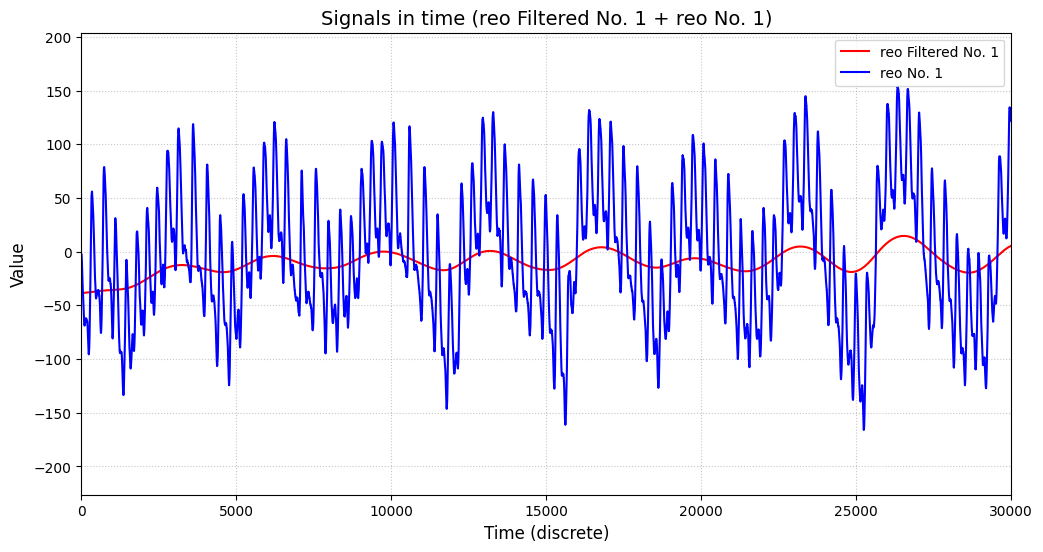

In [13]:
plot_signals_common(signals_dataset=fourth_dataset, 
			label_ecg='reo Filtered No. 1',
			label_reo='reo No. 1',
			column_name_ecg='butterworth_filtered', 
			column_name_reo='column_14', 
			upper_time_limit=30000)

Будем фильтровать сигнал, используя дифференцирующий фильтр

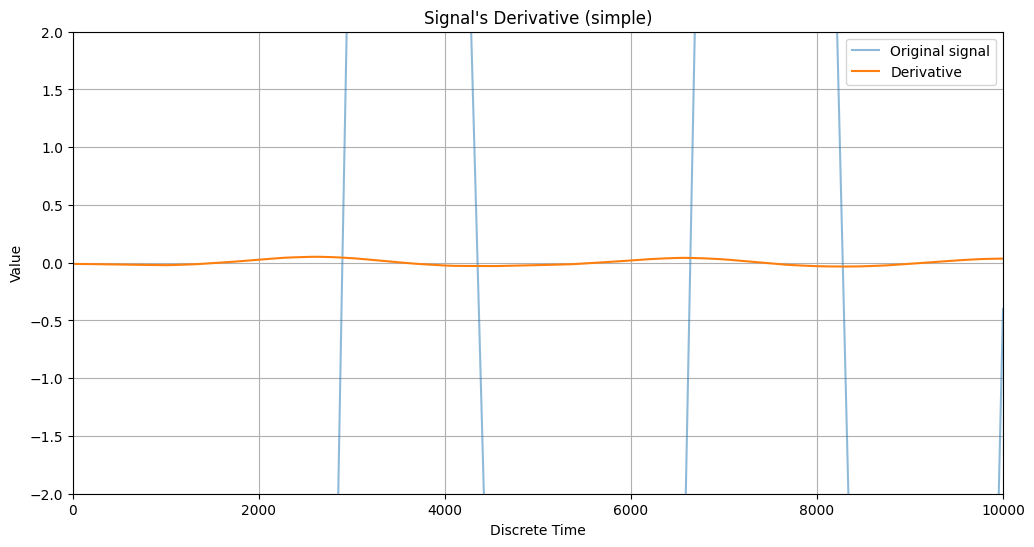

In [14]:
def differentiate_signal(df, column, method='savitzky', window_length=5, polyorder=2, 
						x_column=None, plot=False, figsize=(12, 6), xlim = [0, 10000], normalize=True,
						norm_method = 'max', ylim = [-2, 2]):
	"""
	Вычисление производной сигнала
	
	Параметры:
	df - DataFrame с данными
	column - название колонки с сигналом
	method - метод дифференцирования:
		'simple' - конечные разности
		'savitzky' - фильтр Савицкого-Голей (рекомендуется)
		'fft' - спектральный метод
	window_length - размер окна для Савицкого-Голей
	polyorder - порядок полинома для Савицкого-Голей
	x_column - колонка с x-значениями (время/индекс)
	plot - отображать график
	figsize - размер графика
	
	Возвращает:
	derivative - производная сигнала (в виде массива numpy)
	"""
	signal = df[column].values
	x = df[x_column].values if x_column else np.arange(len(signal))
	
	if method == 'simple':
		derivative = np.gradient(signal, x if x_column else 1)
		
	elif method == 'savitzky':
		derivative = savgol_filter(signal, window_length=window_length, 
								polyorder=polyorder, deriv=1)
		
	elif method == 'fft':
		n = len(signal)
		fft_vals = np.fft.fft(signal)
		freqs = np.fft.fftfreq(n, d=(x[1]-x[0]) if x_column else np.fft.fftfreq(n))
		derivative = np.fft.ifft(2j * np.pi * freqs * fft_vals).real
		
	else:
		raise ValueError("Unknown method. Use 'simple', 'savitzky' или 'fft'")
	
	if normalize:
		if norm_method == 'max':
			derivative = derivative / np.max(np.abs(derivative))
		elif norm_method == 'std':
			derivative = derivative / np.std(derivative)
		elif norm_method == 'range':
			derivative = (derivative - np.min(derivative)) / (np.max(derivative) - np.min(derivative))
		else:
			raise ValueError("Unknown normalization method. Use 'max', 'std' or 'range'")
	
	df['derivative_signal'] = derivative

	if plot:
		plt.figure(figsize=figsize)
		plt.plot(x, signal, label='Original signal', alpha=0.5)
		plt.plot(x, derivative, label='Derivative', linewidth=1.5)
		plt.legend()
		plt.grid(True)
		plt.xlim(xlim)
		plt.ylim(ylim)
		plt.title(f'Signal\'s Derivative ({method})')
		plt.xlabel(x_column if x_column else 'Discrete Time')
		plt.ylabel('Value')
		plt.show()
	
	return df

first_dataset = differentiate_signal(df=first_dataset,
									plot=True,
									normalize=False,
									method='simple',
									column='butterworth_filtered')

second_dataset = differentiate_signal(df=second_dataset,
									plot=False,
									normalize=False,
									method='simple',
									column='butterworth_filtered')

third_dataset = differentiate_signal(df=third_dataset,
									plot=False,
									normalize=False,
									method='simple',
									column='butterworth_filtered')

fourth_dataset = differentiate_signal(df=fourth_dataset,
									plot=False,
									normalize=False,
									method='simple',
									column='butterworth_filtered')


Произведем нормирование сигнала

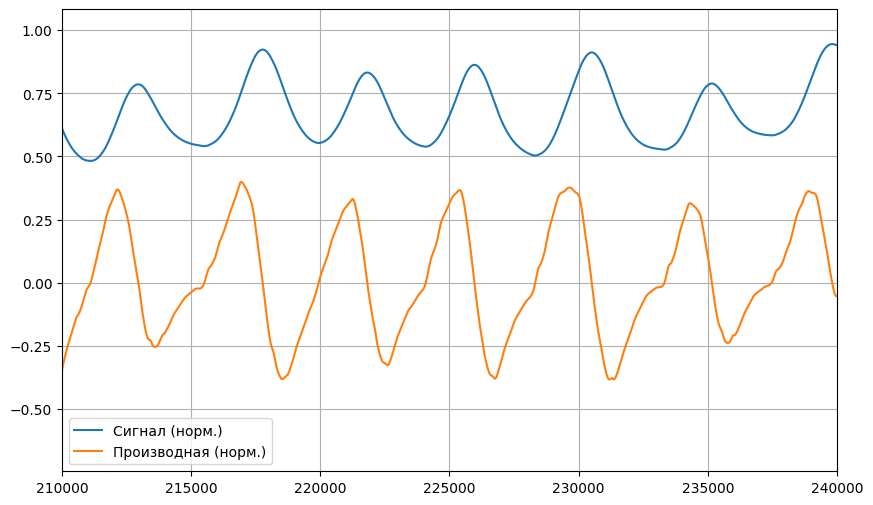

In [15]:
min_b_1 = first_dataset['butterworth_filtered'].min()
max_b_1 = first_dataset['butterworth_filtered'].max()

min_b_2 = second_dataset['butterworth_filtered'].min()
max_b_2 = second_dataset['butterworth_filtered'].max()

min_b_3 = third_dataset['butterworth_filtered'].min()
max_b_3 = third_dataset['butterworth_filtered'].max()

min_b_4 = fourth_dataset['butterworth_filtered'].min()
max_b_4 = fourth_dataset['butterworth_filtered'].max()

global_max = max([max_b_1, max_b_2, max_b_3, max_b_4])
global_min = min([min_b_1, min_b_2, min_b_3, min_b_4])

signal_normalized_first = (first_dataset['butterworth_filtered']- global_min) / (global_max - global_min)  
derivative_normalized_first = first_dataset['derivative_signal'] / first_dataset['derivative_signal'].max()

signal_normalized_second = (second_dataset['butterworth_filtered']- global_min) / (global_max - global_min)  
derivative_normalized_second = second_dataset['derivative_signal'] / second_dataset['derivative_signal'].max()

signal_normalized_third = (third_dataset['butterworth_filtered']- global_min) / (global_max - global_min)  
derivative_normalized_third = third_dataset['derivative_signal'] / third_dataset['derivative_signal'].max()

signal_normalized_fourth = (fourth_dataset['butterworth_filtered']- global_min) / (global_max - global_min)  
derivative_normalized_fourth = fourth_dataset['derivative_signal'] / fourth_dataset['derivative_signal'].max()

t = np.arange(len(first_dataset['butterworth_filtered']))
plt.figure(figsize=(10, 6))
plt.plot(t, signal_normalized_first, label='Сигнал (норм.)')
plt.plot(t, derivative_normalized_first, label='Производная (норм.)')
plt.legend()
plt.xlim([210000, 240000])
plt.grid(True)
plt.show()


Итак, создадим пороговую функцию для разметки данных, основываясь на производной

In [16]:
def make_label(x):
    return 1 if x > 0 else 0

def name_label(x):
    return 'inhale' if x == 1 else 'exhale'

first_dataset['label'] = first_dataset['derivative_signal'].apply(lambda x: make_label(x))
first_dataset['name'] = first_dataset['label'].apply(lambda x: name_label(x))

second_dataset['label'] = second_dataset['derivative_signal'].apply(lambda x: make_label(x))
second_dataset['name'] = second_dataset['label'].apply(lambda x: name_label(x))

third_dataset['label'] = third_dataset['derivative_signal'].apply(lambda x: make_label(x))
third_dataset['name'] = third_dataset['label'].apply(lambda x: name_label(x))

fourth_dataset['label'] = fourth_dataset['derivative_signal'].apply(lambda x: make_label(x))
fourth_dataset['name'] = fourth_dataset['label'].apply(lambda x: name_label(x))

first_dataset.head()

,"ПРКГ(3), мОм","ПРКГ(5), мОм","ПРКГ(7), мОм","ПРКГ(9), мОм","ПРКГ(13), мОм","ПРКГ(15), мОм","ЭКГ(16), мкВ","ПРКГ(18), мОм","ПРКГ(19), мОм","ПРКГ(20), мОм",...,Unnamed: 15,smoothed_ma,smoothed_ema,median_filtered,haar_wavelet,db_wavelet,butterworth_filtered,derivative_signal,label,name
0,-2.4,-2.4,-2.4,-2.8,-2.4,-2.8,12.986,-2.4,-1.2,-2.8,...,NaN,-2.000000,-2.000000,-10.4,-8.982031,-17.947907,-22.132034,-0.010325,0,exhale
1,-2.4,-2.8,-2.8,-2.8,-2.4,-2.8,5.565,-2.4,-1.2,-2.4,...,NaN,-2.000000,-2.000000,-10.4,-8.982031,-17.902574,-22.142358,-0.010329,0,exhale
2,-2.4,-3.2,-2.8,-2.8,-1.6,-2.4,-3.710,-1.6,-0.4,-1.6,...,NaN,-2.133333,-2.134002,-10.4,-8.982031,-17.857220,-22.152692,-0.010338,0,exhale
3,-2.4,-3.2,-3.2,-2.8,-0.4,-2.0,-7.420,-0.4,0.0,-0.8,...,NaN,-2.300000,-2.301756,-10.4,-8.982031,-17.811847,-22.163035,-0.010347,0,exhale
4,-2.8,-3.6,-4.0,-2.4,0.4,-1.6,-3.710,0.8,0.8,0.0,...,NaN,-2.480000,-2.483210,-10.4,-8.982031,-17.766455,-22.173387,-0.010356,0,exhale


Посмотрим результаты:

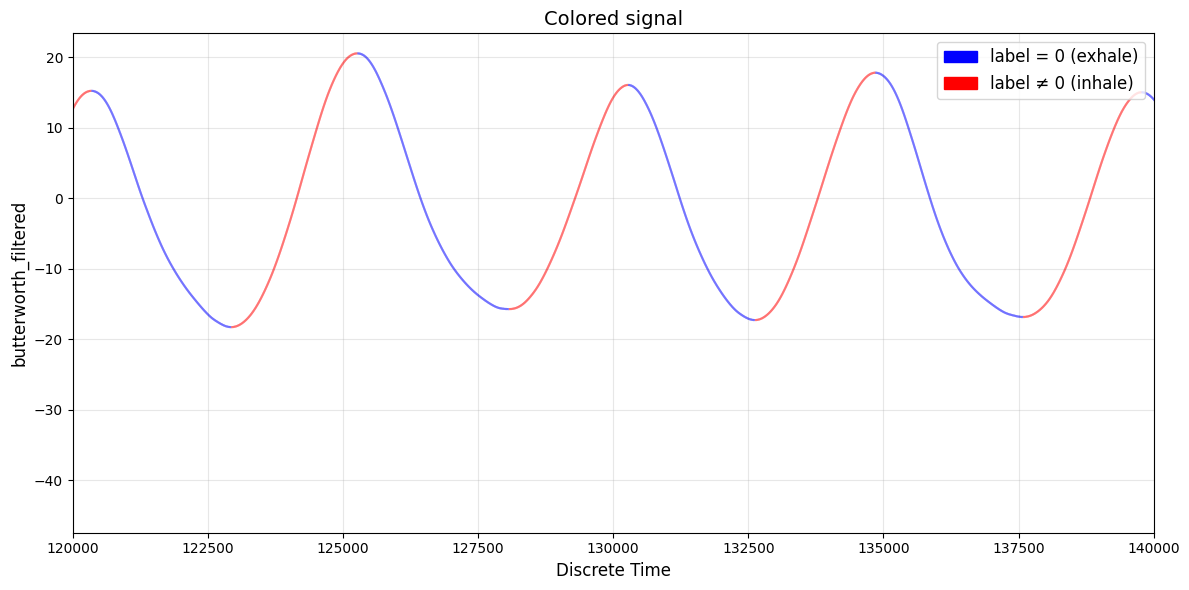

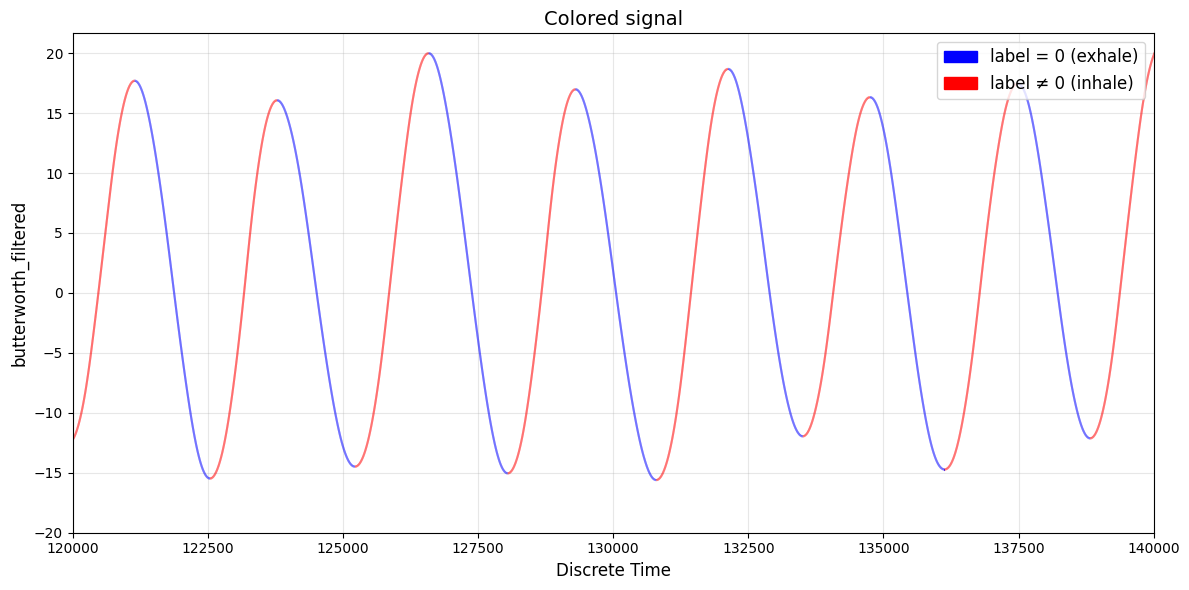

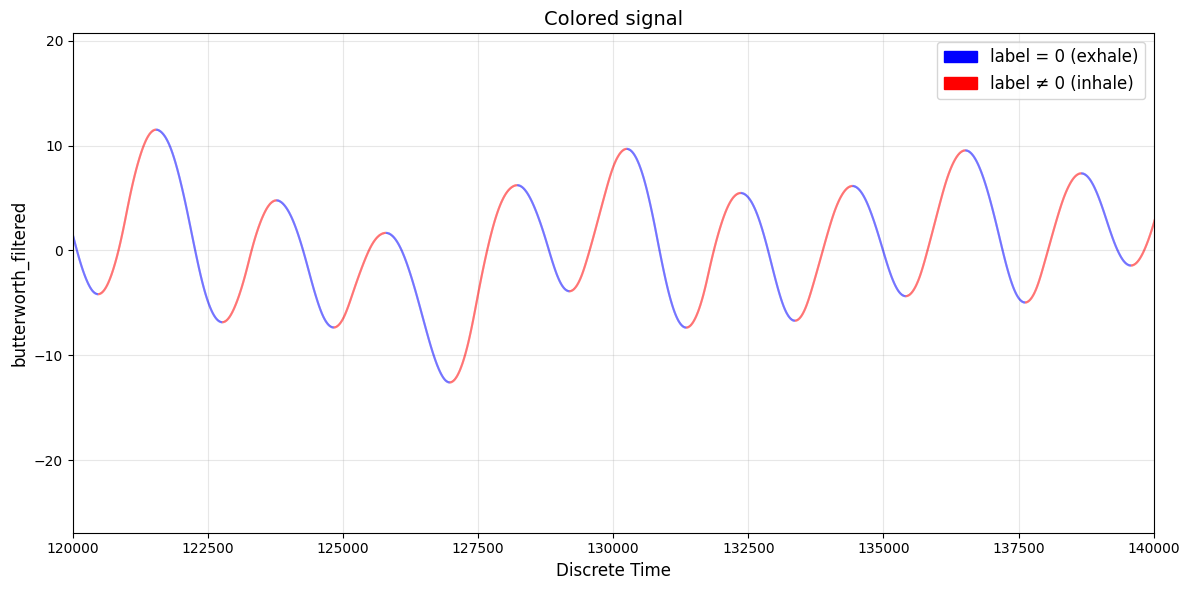

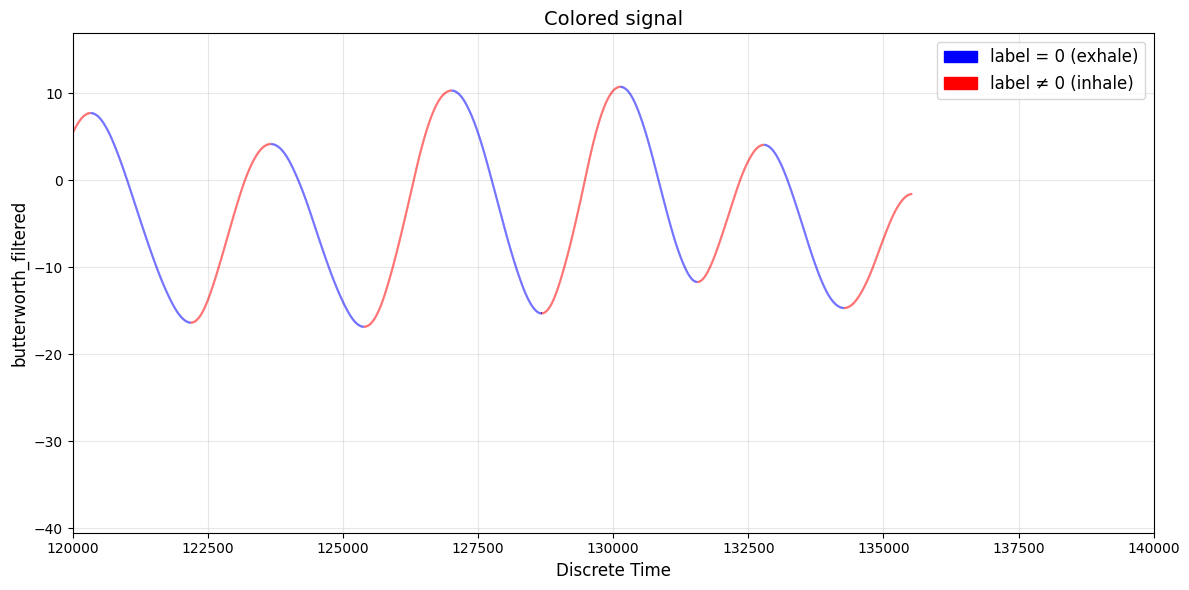

In [17]:
def plot_labeled_signal(
    df, 
    signal_col='butterworth_filtered', 
    label_col='label',
    color_label_0='blue', 
    color_label_other='red',
    title='Colored signal',
    figsize=(12, 6),
    linewidth=1.5,
    alpha=0.7,
    grid_alpha=0.3,
    xlim = [0, 10000]
):
    """
    Рисует график сигнала с раскраской по меткам.
    
    Параметры:
    ----------
    df : pandas.DataFrame
        Датафрейм с колонками сигнала и меток
    signal_col : str (default='butterworth_filtered')
        Название колонки с сигналом
    label_col : str (default='label')
        Название колонки с метками
    color_label_0 : str (default='blue')
        Цвет для метки 0
    color_label_other : str (default='red')
        Цвет для других меток
    title : str (default='Сигнал с раскраской по меткам')
        Заголовок графика
    figsize : tuple (default=(12, 6))
        Размер фигуры
    linewidth : float (default=1.5)
        Толщина линии
    alpha : float (default=0.7)
        Прозрачность линий
    grid_alpha : float (default=0.3)
        Прозрачность сетки
    """
    signal = df[signal_col].values
    labels = df[label_col].values
    
    points = np.array([np.arange(len(signal)), signal]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    colors = np.where(labels[:-1] == 0, color_label_0, color_label_other)
    
    plt.figure(figsize=figsize)
    plt.title(title, fontsize=14)
    plt.xlabel('Discrete Time', fontsize=12)
    plt.ylabel(signal_col, fontsize=12)
    
    lc = LineCollection(
        segments, 
        colors=colors,
        linewidth=linewidth,
        alpha=alpha
    )
    plt.gca().add_collection(lc)
    
    plt.xlim(0, len(signal)-1)
    plt.ylim(np.nanmin(signal)*1.05, np.nanmax(signal)*1.05)
    
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(color=color_label_0, label=f'{label_col} = 0 (exhale)'),
        Patch(color=color_label_other, label=f'{label_col} ≠ 0 (inhale)')
    ]
    plt.legend(handles=legend_elements, fontsize=12)
    
    plt.grid(True, alpha=grid_alpha)
    plt.xlim(xlim)
    
    plt.tight_layout()
    plt.show()

plot_labeled_signal(df=first_dataset, xlim=[120000, 140000])

plot_labeled_signal(df=second_dataset, xlim=[120000, 140000])

plot_labeled_signal(df=third_dataset, xlim=[120000, 140000])

plot_labeled_signal(df=fourth_dataset, xlim=[120000, 140000])

Сохраним датасеты:

In [18]:
# first_dataset.to_csv("../ecg_data/data_ecg_first.csv", index=False)
second_dataset.to_csv("../ecg_data/data_ecg_second.csv", index=False)
third_dataset.to_csv("../ecg_data/data_ecg_third.csv", index=False)
fourth_dataset.to_csv("../ecg_data/data_ecg_fourth.csv", index=False)